In [1]:
import warnings
#warnings.filterwarnings('ignore')

In [100]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
import pandas as pd
import pickle

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

In [3]:
levels = spark.read.csv("../data/20210801_all_levels.csv", header=True, inferSchema=True).cache()
ranking = spark.read.csv("../data/20210801_all_ranking.csv", header=True, inferSchema=True).cache()

levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")

levels.printSchema()
ranking.printSchema()

root
 |-- level: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- specialization: string (nullable = true)
 |-- mastery: string (nullable = true)
 |-- fame: integer (nullable = true)
 |-- guild: string (nullable = true)
 |-- rank: integer (nullable = true)



In [139]:
def get_df(level):
    pivot_expr = ",".join([f"min(if(level=={i}, diff_seconds, null)) as ttl_{i}" for i in range(level) if i > 2])

    df = spark.sql(f"""
    with jobs as (
        select name, job
        from ranking
    ),
    ttl as (
        select
            name,
            job,
            level,
            first(timestamp) over (partition by name order by level) as first_ts,
            lag(timestamp) over (partition by name order by level) as last_ts,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff_seconds,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(first(timestamp) over (partition by name order by level), "Z"))
                as cum_diff_seconds
        from levels
        join jobs
        using (name)
    ),
    pivoted as (
        select
            name,
            job,
            min(if(level={level} and diff_seconds is not null, diff_seconds, 
                unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
                - unix_timestamp(from_utc_timestamp(last_ts, "Z"))
            )) as duration,
            min(if(level={level} and cum_diff_seconds is not null, cum_diff_seconds, 
                unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
                - unix_timestamp(from_utc_timestamp(first_ts, "Z"))
            )) as age,
            max(if(level={level}, 1, 0)) as observed,
            {pivot_expr}
        from ttl
        group by name, job
    )
    select * from pivoted
    where
        duration >=0
        and ttl_{level-2} is not null
        and name = "geospiza"
    """)
    return df.toPandas()

df = get_df(50)
df

,name,job,duration,age,observed,ttl_3,ttl_4,ttl_5,ttl_6,ttl_7,...,ttl_40,ttl_41,ttl_42,ttl_43,ttl_44,ttl_45,ttl_46,ttl_47,ttl_48,ttl_49
0,geospiza,warrior,82042,1466732,1,269,72,133,238,554,...,85238,75196,7755,50716,20360,96900,91543,3837,78881,261401


In [175]:
with open("../data/survival/cox_v1/level_40.pickle", "rb") as fp:
    cph = pickle.load(fp)
cph

<lifelines.CoxPHFitter: fitted with 58297 total observations, 3496 right-censored observations>

In [176]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 58297 total observations, 3496 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 58297
number of events observed = 54801
   partial log-likelihood = -546523.88
         time fit was run = 2021-08-10 01:11:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_30      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_31      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_32      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_33      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_34      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_35      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_36      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_37      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_38      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_39      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

               z      p   -log2(p)
covariate                         
age       -69.99 <0.005        inf
ttl_30     12.44 <0.005     115.61
ttl_31     31.17 <0.005     706.17
ttl_32     21.06 <0.005     324.66
ttl_33     20.04 <0.005     294.22
ttl_34     17.83 <0.005     233.80
ttl_35     13.10 <0.005     127.83
ttl_36     23.75 <0.005     411.83
ttl_37     23.43 <0.005     400.93
ttl_38     14.15 <0.005     148.54
ttl_39     17.54 <0.005     226.27
---
Concordance = 0.66
Partial AIC = 1093069.76
log-likelihood ratio test = 19428.31 on 11 df
-log2(p) of ll-ratio test = inf

In [177]:
cph.params_

covariate
age      -6.765499e-08
ttl_30    6.752560e-08
ttl_31    6.376056e-08
ttl_32    5.877211e-08
ttl_33    6.161644e-08
ttl_34    5.786823e-08
ttl_35    5.512907e-08
ttl_36    5.715106e-08
ttl_37    5.490334e-08
ttl_38    3.778479e-08
ttl_39    4.251763e-08
Name: coef, dtype: float64

In [178]:
s = cph.predict_survival_function(df).join(cph.baseline_survival_)
s

,0,baseline survival
17.0,9.999817e-01,9.999869e-01
85.0,9.999634e-01,9.999738e-01
88.0,9.999451e-01,9.999608e-01
104.0,9.999268e-01,9.999477e-01
115.0,9.999086e-01,9.999346e-01
...,...,...
182442323.0,1.138981e-11,1.489603e-08
182477797.0,1.138981e-11,1.489603e-08
182578824.0,1.138981e-11,1.489603e-08
182690732.0,1.138981e-11,1.489603e-08


In [179]:
s[s.index < 30*24*3600]

,0,baseline survival
17.0,0.999982,0.999987
85.0,0.999963,0.999974
88.0,0.999945,0.999961
104.0,0.999927,0.999948
115.0,0.999909,0.999935
...,...,...
2576045.0,0.010658,0.038847
2584521.0,0.010642,0.038807
2586672.0,0.010642,0.038807
2588062.0,0.010627,0.038768


In [180]:
sec_per_day = 3600*24

In [181]:
cph.predict_median(df)/sec_per_day

0.16931712962962964

In [182]:
z = df.copy()
z["ttl_35"] = z.ttl_35 * 100
cph.predict_median(z)/sec_per_day

0.07517361111111111

In [183]:
x = s.reset_index()
x.columns = ["time", "char", "baseline"]
x["time"] = x.time / sec_per_day
x = x[x.time < 1]
x

,time,char,baseline
0,0.000197,0.999982,0.999987
1,0.000984,0.999963,0.999974
2,0.001019,0.999945,0.999961
3,0.001204,0.999927,0.999948
4,0.001331,0.999909,0.999935
...,...,...,...
25080,0.999583,0.189832,0.304706
25081,0.999711,0.189814,0.304685
25082,0.999769,0.189796,0.304664
25083,0.999803,0.189777,0.304642


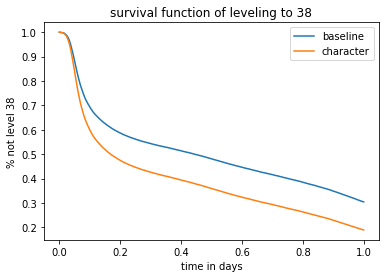

In [184]:
import matplotlib.pyplot as plt

plt.plot(x.time, x.baseline, label="baseline")
plt.plot(x.time, x.char, label="character")
plt.legend()
plt.title("survival function of leveling to 38")
plt.xlabel("time in days")
plt.ylabel("% not level 38")
plt.show()

## making a bunch of plots

In [185]:
df = get_df(140)

In [186]:
df

,name,job,duration,age,observed,ttl_3,ttl_4,ttl_5,ttl_6,ttl_7,...,ttl_130,ttl_131,ttl_132,ttl_133,ttl_134,ttl_135,ttl_136,ttl_137,ttl_138,ttl_139
0,geospiza,warrior,1492347,27905598,1,269,72,133,238,554,...,518165,524503,1118141,327134,442597,443552,416358,452995,516114,2130563


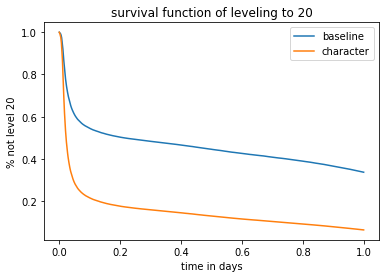

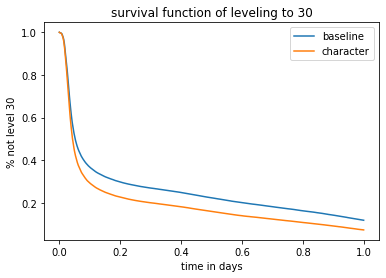

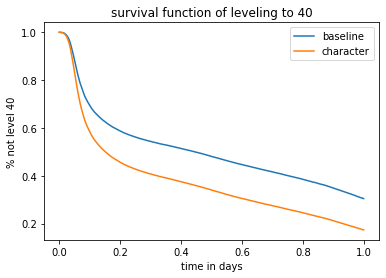

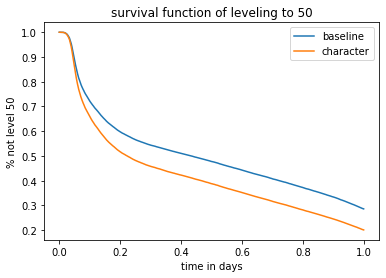

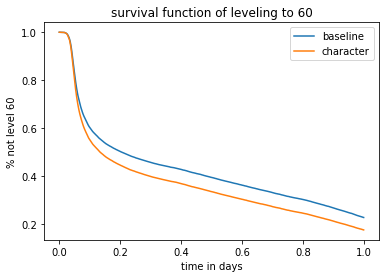

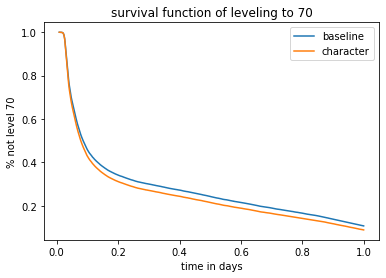

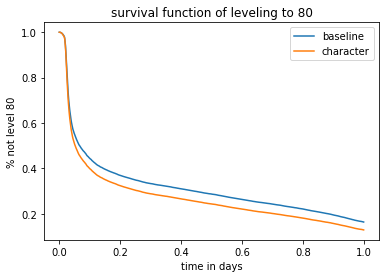

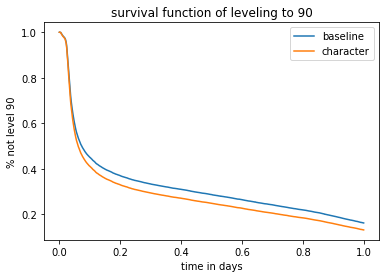

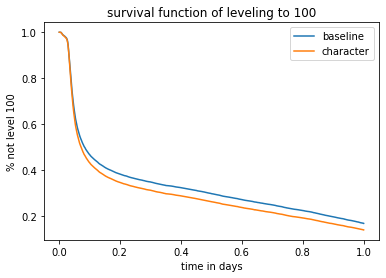

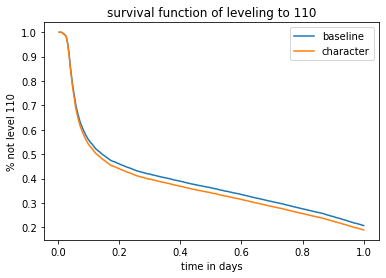

In [192]:
for i in range(20, 120, 10):
    df = get_df(i)

    with open(f"../data/survival/cox_v1/level_{i}.pickle", "rb") as fp:
        cph = pickle.load(fp)
    
    s = cph.predict_survival_function(df).join(cph.baseline_survival_)
    x = s.reset_index()
    x.columns = ["time", "char", "baseline"]
    x["time"] = x.time / sec_per_day
    x = x[x.time < 1]
    
    plt.plot(x.time, x.baseline, label="baseline")
    plt.plot(x.time, x.char, label="character")
    plt.legend()
    plt.title(f"survival function of leveling to {i}")
    plt.xlabel("time in days")
    plt.ylabel(f"% not level {i}")
    plt.show()

In [197]:
i = 33

with open(f"../data/survival/cox_v1/level_{i}.pickle", "rb") as fp:
    cph = pickle.load(fp)

cph

<lifelines.CoxPHFitter: fitted with 73591 total observations, 4978 right-censored observations>

In [198]:
dir(cph)

['AIC_',
 'AIC_partial_',
 '_ALLOWED_RESIDUALS',
 '_FAST_MEDIAN_PREDICT',
 '_KNOWN_MODEL',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_mode',
 '_censoring_type',
 '_central_values',
 '_check_values_post_fitting',
 '_check_values_pre_fitting',
 '_choose_gradient_calculator',
 '_class_name',
 '_clusters',
 '_compute_baseline_cumulative_hazard',
 '_compute_baseline_hazard',
 '_compute_baseline_hazards',
 '_compute_baseline_survival',
 '_compute_central_values_of_raw_training_data',
 '_compute_confidence_intervals',
 '_compute_delta_beta',
 '_compute_deviance',
 '_compute_martingale',
 '_compute_p_values',
 '_compute_sandwich_estimator',
 '_

In [291]:
cph.durations.size, cph.event_observed.sum(), cph._time_fit_was_called, cph._class_name

(73591, 68613, '2021-08-10 01:07:44 UTC', 'CoxPHFitter')

<AxesSubplot:xlabel='log(HR) (95% CI)'>

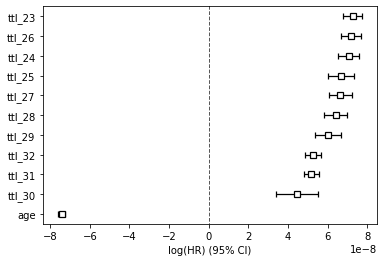

In [210]:
cph.plot()

In [200]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 73591 total observations, 4978 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 73591
number of events observed = 68613
   partial log-likelihood = -699968.27
         time fit was run = 2021-08-10 01:07:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_23      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_24      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_25      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_26      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_27      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_28      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_29      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_30      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_31      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_32      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

               z      p   -log2(p)
covariate                         
age       -75.87 <0.005        inf
ttl_23     30.10 <0.005     658.66
ttl_24     25.56 <0.005     476.45
ttl_25     19.89 <0.005     290.04
ttl_26     27.41 <0.005     547.05
ttl_27     22.88 <0.005     382.35
ttl_28     21.72 <0.005     344.95
ttl_29     17.61 <0.005     228.16
ttl_30      8.25 <0.005      52.45
ttl_31     26.19 <0.005     499.64
ttl_32     25.12 <0.005     459.98
---
Concordance = 0.66
Partial AIC = 1399958.53
log-likelihood ratio test = 27229.84 on 11 df
-log2(p) of ll-ratio test = inf

In [322]:
x.loc[x.baseline <= 0.5].iloc[0].time

0.1632523148148148

In [326]:
x.loc[x.baseline <= 0.5].iloc[0].time

0.1632523148148148

In [327]:
[
    [f"{i}th percentile", 
     f"{x.loc[x.baseline <= i/100].iloc[0].time}", 
     f"{x.loc[x.char <= i/100].iloc[0].time}"]
    for i in [90, 75, 50]
]

[['90th percentile', '0.020381944444444446', '0.02130787037037037'],
 ['75th percentile', '0.03616898148148148', '0.04076388888888889'],
 ['50th percentile', '0.1632523148148148', '0.2646527777777778']]

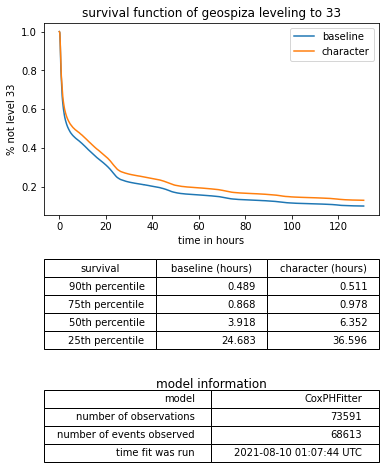

In [438]:
def plot(cph, df, level, name):
    s = cph.predict_survival_function(df).join(cph.baseline_survival_)
    x = s.reset_index()
    x.columns = ["time", "char", "baseline"]
    sec_per_hour = 3600
    x["time"] = x.time / sec_per_hour
    min_val = min([x.char.min(), x.baseline.min()])

    # get within 10% of the min baseline
    min_base = x.baseline.min() + .1
    z = x[x.baseline >= min_base]


    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), gridspec_kw={'height_ratios': [6, 4, 2]})

    ax1.set_title(f"survival function of {name} leveling to {level}")
    ax1.plot(z.time, z.baseline, label=f"baseline")
    ax1.plot(z.time, z.char, label=f"character")
    ax1.set_xlabel("time in hours")
    ax1.set_ylabel(f"% not level {level}")
    ax1.legend()
    
    ax2.axis("off")
    data = ax2.table(
        cellText=[
            [f"{i}th percentile", 
             f"{x.loc[x.baseline <= i/100].iloc[0].time:.3f}", 
             f"{x.loc[x.char <= i/100].iloc[0].time:.3f}"]
            for i in [90, 75, 50, 25]
            if i/100 > min_val
        ],
        colLabels=["survival", "baseline (hours)", "character (hours)"],
        loc="center"
    )
    data.scale(1, 1.5)

    ax3.set_title(f"model information")
    ax3.axis("off")
    table = ax3.table(
        cellText=[
            ["model", cph._class_name],
            ["number of observations", cph.durations.size], 
            ["number of events observed", cph.event_observed.sum()], 
            ["time fit was run", cph._time_fit_was_called]
        ],
        loc="center"
    )
    table.scale(1, 1.5)

    plt.show()

with open(f"../data/survival/cox_v1/level_33.pickle", "rb") as fp:
    cph = pickle.load(fp)
plot(cph, df, 33, "geospiza")

In [418]:
import requests
from bs4 import BeautifulSoup

def parse_levels_row(tr):
    td = tr.find_all("td")
    return dict(
        level=int(td[0].getText()),
        timestamp=td[1].getText().replace(" ", "T"),
    )


def parse_levels_page(resp):
    soup = BeautifulSoup(resp.text)
    name = resp.url.split("=")[-1]
    rows = soup.find_all("tr")[1:]
    return dict(name=name, history=[parse_levels_row(tr) for tr in rows])


def get_levels(name):
    url = f"https://maplelegends.com/levels?name={name}"
    return requests.get(url)


In [338]:
levels = parse_levels_page(get_levels("geospiza"))
levels

{'name': 'geospiza',
 'history': [{'level': 145, 'timestamp': '2021-08-01T01:08:07'},
  {'level': 144, 'timestamp': '2021-06-19T20:55:46'},
  {'level': 143, 'timestamp': '2021-05-23T23:30:50'},
  {'level': 142, 'timestamp': '2021-04-28T02:57:30'},
  {'level': 141, 'timestamp': '2021-03-21T03:22:02'},
  {'level': 140, 'timestamp': '2021-03-05T02:43:26'},
  {'level': 139, 'timestamp': '2021-02-15T20:10:59'},
  {'level': 138, 'timestamp': '2021-01-22T04:21:36'},
  {'level': 137, 'timestamp': '2021-01-16T04:59:42'},
  {'level': 136, 'timestamp': '2021-01-10T23:09:47'},
  {'level': 135, 'timestamp': '2021-01-06T03:30:29'},
  {'level': 134, 'timestamp': '2021-01-01T00:17:57'},
  {'level': 133, 'timestamp': '2020-12-26T21:21:20'},
  {'level': 132, 'timestamp': '2020-12-23T02:29:06'},
  {'level': 131, 'timestamp': '2020-12-10T03:53:25'},
  {'level': 130, 'timestamp': '2020-12-04T02:11:42'},
  {'level': 129, 'timestamp': '2020-11-28T02:15:37'},
  {'level': 128, 'timestamp': '2020-11-22T00:30:04

In [367]:
level_df = pd.DataFrame(levels["history"]).sort_values("level")
level_df["ts"] = pd.to_datetime(level_df.timestamp)

In [368]:
level_df["ttl"] = level_df.ts.diff().dt.total_seconds()
level_df["cum_ttl"] = level_df.ttl.cumsum()
level_df

,level,timestamp,ts,ttl,cum_ttl
143,2,2020-04-16T04:10:08,2020-04-16 04:10:08,NaN,NaN
142,3,2020-04-16T04:14:37,2020-04-16 04:14:37,269.0,269.0
141,4,2020-04-16T04:15:49,2020-04-16 04:15:49,72.0,341.0
140,5,2020-04-16T04:18:02,2020-04-16 04:18:02,133.0,474.0
139,6,2020-04-16T04:22:00,2020-04-16 04:22:00,238.0,712.0
...,...,...,...,...,...
4,141,2021-03-21T03:22:02,2021-03-21 03:22:02,1384716.0,29286714.0
3,142,2021-04-28T02:57:30,2021-04-28 02:57:30,3281728.0,32568442.0
2,143,2021-05-23T23:30:50,2021-05-23 23:30:50,2234000.0,34802442.0
1,144,2021-06-19T20:55:46,2021-06-19 20:55:46,2323496.0,37125938.0


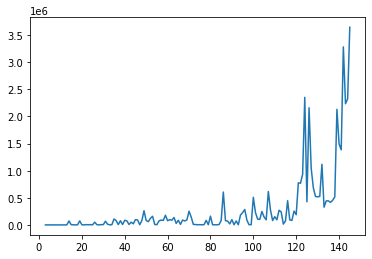

In [373]:
plt.plot(level_df.level, level_df.ttl)

In [377]:
data = level_df.to_dict(orient="records")
data

[{'level': 2,
  'timestamp': '2020-04-16T04:10:08',
  'ts': Timestamp('2020-04-16 04:10:08'),
  'ttl': nan,
  'cum_ttl': nan},
 {'level': 3,
  'timestamp': '2020-04-16T04:14:37',
  'ts': Timestamp('2020-04-16 04:14:37'),
  'ttl': 269.0,
  'cum_ttl': 269.0},
 {'level': 4,
  'timestamp': '2020-04-16T04:15:49',
  'ts': Timestamp('2020-04-16 04:15:49'),
  'ttl': 72.0,
  'cum_ttl': 341.0},
 {'level': 5,
  'timestamp': '2020-04-16T04:18:02',
  'ts': Timestamp('2020-04-16 04:18:02'),
  'ttl': 133.0,
  'cum_ttl': 474.0},
 {'level': 6,
  'timestamp': '2020-04-16T04:22:00',
  'ts': Timestamp('2020-04-16 04:22:00'),
  'ttl': 238.00000000000003,
  'cum_ttl': 712.0},
 {'level': 7,
  'timestamp': '2020-04-16T04:31:14',
  'ts': Timestamp('2020-04-16 04:31:14'),
  'ttl': 554.0,
  'cum_ttl': 1266.0},
 {'level': 8,
  'timestamp': '2020-04-16T04:41:58',
  'ts': Timestamp('2020-04-16 04:41:58'),
  'ttl': 644.0,
  'cum_ttl': 1910.0},
 {'level': 9,
  'timestamp': '2020-04-16T04:46:53',
  'ts': Timestamp('20

In [400]:
df

,name,job,duration,age,observed,ttl_3,ttl_4,ttl_5,ttl_6,ttl_7,...,ttl_100,ttl_101,ttl_102,ttl_103,ttl_104,ttl_105,ttl_106,ttl_107,ttl_108,ttl_109
0,geospiza,warrior,151773,8096522,1,269,72,133,238,554,...,508903,226963,107726,101906,247801,148010,93927,616087,273741,80420


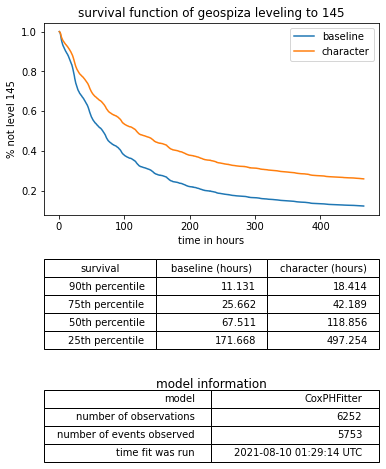

In [439]:
import numpy as np

d = {}
d["age"] = level_df.cum_ttl.max()
d["observed"] = 0
for _, row in level_df.iterrows():
    if np.isnan(row.ttl):
        continue
    d[f"ttl_{row.level}"] = row.ttl

level = level_df.level.max()
with open(f"../data/survival/cox_v1/level_{level}.pickle", "rb") as fp:
    cph = pickle.load(fp)

plot(cph, pd.DataFrame([d]), level, "geospiza")